In [1]:
import numpy as np
import pandas as pd
import random
import glob
import math
import xgboost
from sklearn import preprocessing
import lightgbm as lgb
import altair as alt

from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')


/home/deepracer/MADS-Medicare-Project/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Get list of files for the Geo grouped data
# Data sourced from https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-geography-and-service
data_files_list = glob.glob('data/MUP*Geo.csv')
data_files_list 

# For training use 2013 to 2016 to predict 2017
# For testing use 2014 to 2017 to predict 2018
# for validation use 2015 to 2018 to predict 2019

# For presentation use 2016 to 2019 to predict 2020 (and compare against 2019)

['data/MUP_PHY_R19_P04_V10_D17_Geo.csv',
 'data/MUP_PHY_R20_P04_V10_D18_Geo.csv',
 'data/MUP_PHY_R19_P04_V10_D13_Geo.csv',
 'data/MUP_PHY_R19_P04_V10_D15_Geo.csv',
 'data/MUP_PHY_R19_P04_V10_D16_Geo.csv',
 'data/MUP_PHY_R21_P04_V10_D19_Geo.csv',
 'data/MUP_PHY_R19_P04_V10_D14_Geo.csv']

In [3]:
df_geo_full = []
for _file in data_files_list:
    df_geo = pd.read_csv(
         _file,
         header=0, 
         #skiprows=lambda i: i>0 and random.random() > p
    )
    year= _file[-10:-8]
    df_geo['year'] = 2000+int(year)
    if len(df_geo_full)!=0:
        df_geo_full = df_geo_full.append(df_geo, ignore_index=False)
    else:
        df_geo_full = df_geo.copy()

df_geo_full= df_geo_full.loc[df_geo_full['year']!= 0,:]

excl_states =  ['Armed Forces Central/South America', 'Armed Forces Europe', 'Armed Forces Pacific', 'Foreign Country','National','Unknown', 'American Samoa',
               'Guam', 'Northern Mariana Islands', 'Puerto Rico', 'Virgin Islands']
df_geo_full = df_geo_full.loc[~df_geo_full['Rndrng_Prvdr_Geo_Desc'].isin(excl_states),:].copy()

In [38]:
len(df_geo_full)

1760035

In [4]:
# Prep geo_full for train/test/val

df_geo_features = df_geo_full.loc[:,['Rndrng_Prvdr_Geo_Desc', 'HCPCS_Cd', 'Tot_Srvcs','year']].copy()
df_geo_features = df_geo_features.groupby(['Rndrng_Prvdr_Geo_Desc', 'HCPCS_Cd','year'])[ 'Tot_Srvcs'].sum().reset_index()
df_geo_features.loc[:,'Tot_Srvcs'] = df_geo_features['Tot_Srvcs'].apply(lambda x: math.log(x))

df_geo_features.loc[:,'idx'] = df_geo_features.apply(lambda x:  "_".join([str(x['Rndrng_Prvdr_Geo_Desc']), str(x['HCPCS_Cd'])]), axis=1)
start_year = 2013
no_of_years = 4
df_geo_features.loc[:,'year'] = start_year + no_of_years - df_geo_features['year'] 
df_geo_features_train = df_geo_features.loc[df_geo_features['year']>=0,:].copy()
df_geo_features_train = df_geo_features_train.loc[df_geo_features_train['year'] <= no_of_years,:]

df_geo_features_test = df_geo_features.loc[df_geo_features['year']>=-1,:].copy()
df_geo_features_test.loc[:,'year'] = df_geo_features_test['year'] + 1
df_geo_features_test = df_geo_features_test.loc[df_geo_features_test['year']<=no_of_years,:].copy()

df_geo_features_train = df_geo_features_train.pivot(index=['idx'], columns=['year'], values='Tot_Srvcs')
df_geo_features_test = df_geo_features_test.pivot(index=['idx'], columns=['year'], values='Tot_Srvcs')

col_map = {
    0: "target",
    1: "1",
    2: "2",
    3: "3",
    4: "4"
}

df_geo_features_train.rename(columns = col_map, inplace=True)
df_geo_features_test.rename(columns = col_map, inplace=True)

df_geo_features_train['state'] = df_geo_features_train.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values
df_geo_features_test['state'] = df_geo_features_test.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values

df_geo_features_train.reset_index(inplace=True)
df_geo_features_test.reset_index(inplace=True)

df_geo_features_train.fillna(0, inplace=True)
df_geo_features_test.fillna(0, inplace=True)



In [5]:
df_geo_features_test.sample(5)

year,idx,target,1,2,3,4,state
107063,Michigan_63012,4.553877,4.762174,4.919981,4.787492,5.147494,Michigan
109122,Michigan_95930,7.789869,8.259199,8.515392,8.670258,8.459352,Michigan
161033,North Carolina_Q4021,5.793014,5.869297,6.006353,5.953243,5.894403,North Carolina
215738,Virginia_01482,6.885510,6.759255,6.801283,6.761573,6.710523,Virginia
219107,Virginia_77778,5.583496,5.598422,5.529429,5.541264,5.209486,Virginia


In [6]:
df_geo_features_train.sample(5)

year,idx,target,1,2,3,4,state
161876,North Dakota_51736,2.564949,0.000000,0.000000,0.000000,0.000000,North Dakota
149627,New York_30465,5.293305,5.170484,4.753590,4.672829,4.615121,New York
177444,Oregon_84160,0.000000,3.850148,0.000000,0.000000,0.000000,Oregon
125378,Montana_45381,6.003887,5.662960,5.659482,5.602119,5.697093,Montana
63926,Illinois_86300,9.118115,9.201199,9.273409,9.186969,9.235326,Illinois


In [7]:
# Import population estimates data
pop_est = pd.read_csv("data/SC-EST2020-ALLDATA5.csv")

# Drop columns that is not needed for "one row" melting
pop_est.drop(['SUMLEV', 'REGION', 'DIVISION', 'STATE'], axis='columns', inplace=True)

In [40]:
len(pop_est)

197370

In [9]:
pop_est['age_category'] =  pop_est['AGE'].apply(lambda x: 1 if x >40  else 0) 
#pop_est['idx'] = pop_est.apply(lambda x:  "_".join([str(x['SEX']), str(x['ORIGIN']), str(x['RACE']), str(x['AGE'])]), axis=1)
pop_est.drop(['SEX', 'ORIGIN', 'RACE', 'AGE'], axis='columns', inplace=True)

In [10]:
pop_agg_df = pop_est.copy()
pop_agg_df.drop(['CENSUS2010POP','ESTIMATESBASE2010'], axis = 'columns', inplace=True)

pop_agg_df = pd.melt(pop_agg_df,id_vars=['NAME','age_category'])

pop_agg_df.loc[:,'year'] = pop_agg_df['variable'].apply(lambda x: int(x[-4:]))
#popestimate df
pop_agg_df.drop(['variable'], axis='columns', inplace=True)

pop_agg_df = pop_agg_df.groupby(['NAME','age_category','year']).sum().reset_index()
# set t=0 for base year

# set year count to integers from 0 to x for train and test split
start_year = 2013
no_of_years = 4
pop_agg_df.loc[:,'year'] = start_year + no_of_years - pop_agg_df['year'] 
pop_train_df = pop_agg_df.loc[pop_agg_df['year']>0,:].copy()
pop_train_df = pop_train_df.loc[pop_train_df['year'] <= no_of_years,:]
pop_test_df = pop_agg_df.loc[pop_agg_df['year']>-1,:].copy()
pop_test_df.loc[:,'year'] = pop_test_df['year'] + 1
pop_test_df = pop_test_df.loc[pop_test_df['year'] <= no_of_years,:]

pop_train_df.loc[:,'idx'] = pop_train_df.apply(lambda x:  "_".join([str(x['age_category']), str(x['year'])]), axis=1)
pop_train_df = pop_train_df.pivot(index='NAME', columns=['idx'], values='value')

pop_test_df.loc[:,'idx'] = pop_test_df.apply(lambda x:  "_".join([str(x['age_category']), str(x['year'])]), axis=1)
pop_test_df = pop_test_df.pivot(index='NAME', columns=['idx'], values='value')

# normalise values based on train data only

_mean = pop_train_df.stack().mean()
_std = pop_train_df.stack().std()

pop_train_df = (pop_train_df-_mean)/_std
pop_test_df = (pop_test_df-_mean)/_std

pop_train_df.index.name = 'state'
pop_test_df.index.name = 'state'

pop_train_df.reset_index(inplace=True)
pop_test_df.reset_index(inplace=True)

In [11]:
pop_train_df.sample(3)

idx,state,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
32,New York,2.041380,2.052940,2.056700,2.059056,1.671264,1.662135,1.653787,1.640603
26,Montana,-0.720007,-0.721793,-0.723438,-0.724984,-0.732440,-0.733785,-0.734737,-0.735714
17,Kentucky,-0.217616,-0.218388,-0.219366,-0.218949,-0.299604,-0.302682,-0.305719,-0.309545


In [12]:
pop_test_df.sample(3)

idx,state,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
50,Wyoming,-0.783313,-0.781783,-0.781225,-0.781926,-0.798589,-0.798755,-0.799054,-0.799364
41,South Dakota,-0.736274,-0.738188,-0.739969,-0.740969,-0.763757,-0.764751,-0.765655,-0.766213
25,Missouri,0.036166,0.032899,0.031488,0.028760,-0.084719,-0.088102,-0.092177,-0.095076


In [13]:
full_train = df_geo_features_train.merge(pop_train_df, on='state',how='left').drop(['state'], axis = 1).set_index('idx')
full_test = df_geo_features_test.merge(pop_test_df, on='state',how='left').drop(['state'], axis = 1).set_index('idx')

In [14]:
full_test.sample(5)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4
idx,,,,,,,,,,,,,
New Mexico_87633,2.995732,0.000000,3.044522,0.000000,0.000000,-0.554621,-0.553396,-0.552650,-0.551668,-0.606018,-0.607612,-0.609321,-0.610451
Colorado_83036,11.741836,11.595261,11.505911,11.625674,11.691440,0.018745,0.007310,-0.006639,-0.024039,-0.190727,-0.200887,-0.212898,-0.224931
Vermont_27506,3.218876,2.639057,2.890372,3.135494,2.397895,-0.787337,-0.787467,-0.787135,-0.787149,-0.782392,-0.782554,-0.782560,-0.782619
Rhode Island_66982,7.848153,8.142354,8.507749,7.901377,6.956545,-0.718080,-0.717795,-0.718025,-0.718158,-0.729686,-0.729805,-0.730048,-0.730179
Delaware_28118,3.258097,3.295837,0.000000,2.890372,0.000000,-0.733901,-0.734477,-0.734897,-0.735719,-0.741599,-0.743420,-0.745366,-0.747187


In [15]:
best_params = {'colsample_bytree': 0.9682038820754064,
 'gamma': 1.0184993645158578,
 'max_depth': int(12.0),
 'min_child_weight': int(8.0),
 'n_estimators': int(6),
 'reg_alpha': 113.0,
 'reg_lambda': 0.08792023426025397}

model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=1.0184993645158578,                 
                 learning_rate=0.007,
                 max_depth=12,
                 min_child_weight=8,
                 n_estimators=100000,                                                                    
                 reg_alpha=0,
                 reg_lambda=0,
                 subsample=0.8,
                 seed=117,
                            ) 


In [16]:
x_train = full_train.drop(["target"], axis=1)
y_train = full_train['target']
x_test = full_test.drop(["target"], axis=1)
y_test= full_test['target']

In [17]:
model.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test,y_test)], early_stopping_rounds=50,verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, enable_categorical=False,
             gamma=1.0184993645158578, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.007, max_delta_step=0,
             max_depth=12, min_child_weight=8, missing=nan,
             monotone_constraints='()', n_estimators=100000, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=117,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=117,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [18]:
model.save_model("model.json")

In [ ]:

model.load_model("model.json")

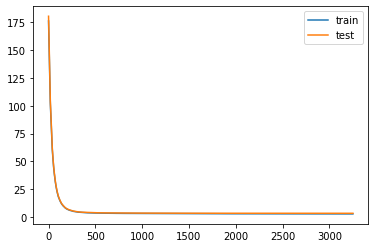

In [19]:
results = model.evals_result()
# plot learning curves
_train_results = np.array(list(map(math.exp,results['validation_0']['rmse'])))
_test_results = np.array(list(map(math.exp,results['validation_1']['rmse'])))
pyplot.plot(_train_results, label='train')
pyplot.plot(_test_results, label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [20]:
y_pred = model.predict(x_test)

In [21]:
full_test['state'] = full_test.reset_index()['idx'].apply(lambda x: x.split("_")[0]).values

In [22]:
def perc_round(x):
    return round(x,-2)

full_test['pred'] = np.array(list(map(math.exp,y_pred)))
full_test['target_original'] = np.array(list(map(math.exp,full_test['target'])))
full_test['total_diff'] = np.array(list(map(round, full_test['target_original'] - full_test['pred'])))
full_test['perc_diff'] = full_test['total_diff'].values/full_test['target_original'].values

In [23]:
full_test['baseline_pred'] = np.array(list(map(math.exp,full_test['1'])))*1.05
full_test['baseline_perc_diff'] = (full_test['baseline_pred'].values/full_test['target_original'].values)-1

In [24]:
full_test = full_test.loc[full_test['target']>0,:]

In [25]:
full_test.sample(5)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff,baseline_pred,baseline_perc_diff
idx,,,,,,,,,,,,,,,,,,,,
New Jersey_38242,3.401197,2.833213,3.135494,3.496508,0.000000,0.406448,0.404752,0.407474,0.409549,0.312633,0.309062,0.304248,0.299973,New Jersey,7.937708,30.0,22,0.733333,17.85,-0.405000
Montana_64415,7.060476,6.943122,6.981935,6.966024,6.888572,-0.718028,-0.720007,-0.721793,-0.723438,-0.730920,-0.732440,-0.733785,-0.734737,Montana,925.265302,1165.0,240,0.206009,1087.80,-0.066266
New York_78598,5.855072,6.018593,5.802118,6.198479,6.453625,2.028074,2.041380,2.052940,2.056700,1.675851,1.671264,1.662135,1.653787,New York,310.296362,349.0,39,0.111748,431.55,0.236533
Arizona_A4561,4.406719,3.951244,3.465736,3.218876,3.526361,0.207604,0.196971,0.184604,0.173674,0.015564,-0.003810,-0.023994,-0.042012,Arizona,41.408876,82.0,41,0.500000,54.60,-0.334146
Indiana_30130,3.496508,3.526361,3.401197,3.555348,4.276666,0.136116,0.132698,0.129465,0.127967,-0.036773,-0.041149,-0.046395,-0.050199,Indiana,24.220846,33.0,9,0.272727,35.70,0.081818


In [26]:
full_test_sum = full_test.groupby(['state']).mean()
full_test_sum['perc_diff'] = full_test_sum['total_diff'].values/full_test_sum['target_original'].values
full_test_sum

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,pred,target_original,total_diff,perc_diff,baseline_pred,baseline_perc_diff
state,,,,,,,,,,,,,,,,,,,
Alabama,5.770404,5.556648,5.537650,5.429029,5.295684,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,13257.648992,14856.048787,1598.415539,0.107594,15265.154857,0.210199
Alaska,5.017143,4.567637,4.310002,4.122252,3.891912,-0.738980,-0.738410,-0.739370,-0.739752,-0.786242,-0.786586,-0.787076,-0.787268,2125.365425,2451.906755,326.542082,0.133179,2373.306337,-0.043677
Arizona,5.901255,5.570376,5.404724,5.228163,5.050828,0.207604,0.196971,0.184604,0.173674,0.015564,-0.003810,-0.023994,-0.042012,13851.310013,16330.275778,2478.966547,0.151802,15967.326501,0.055218
Arkansas,5.579282,5.265700,5.126279,4.990361,4.836603,-0.422374,-0.423939,-0.425101,-0.426399,-0.489533,-0.491847,-0.494542,-0.496743,9325.302484,10530.857720,1205.566960,0.114479,10437.525239,0.092669
California,6.404954,6.152116,6.002425,5.827324,5.698426,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,39789.491943,53422.594569,13633.109992,0.255194,50267.614142,0.100932
Colorado,5.588875,5.279117,5.112318,4.962775,4.817071,0.018745,0.007310,-0.006639,-0.024039,-0.190727,-0.200887,-0.212898,-0.224931,7854.892047,9646.626548,1791.718440,0.185735,9290.597167,0.061824
Connecticut,5.460618,5.280385,5.164732,5.121353,4.998182,-0.366636,-0.366110,-0.364265,-0.362967,-0.383384,-0.383339,-0.383399,-0.383345,6528.257258,7411.775197,883.511014,0.119204,8534.024547,0.168939
Delaware,5.297862,4.984609,4.754627,4.614628,4.456951,-0.733901,-0.734477,-0.734897,-0.735719,-0.741599,-0.743420,-0.745366,-0.747187,3475.666873,4439.884878,964.202567,0.217168,4384.891817,0.058669
District of Columbia,4.961503,4.601102,4.395567,4.262507,4.099844,-0.749293,-0.751808,-0.754006,-0.756969,-0.798362,-0.798635,-0.799487,-0.800356,1725.906455,1986.092878,260.203540,0.131013,1854.241903,0.015597


In [27]:
full_test.sort_values('pred',ascending=False)

,target,1,2,3,4,0_1,0_2,0_3,0_4,1_1,1_2,1_3,1_4,state,pred,target_original,total_diff,perc_diff,baseline_pred,baseline_perc_diff
idx,,,,,,,,,,,,,,,,,,,,
California_Q9967,16.107760,16.059161,16.023511,15.941482,15.959088,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,California,1.044690e+07,9897179.7,-549718,-0.055543,9.899070e+06,0.000191
California_99213,15.977317,16.004393,16.029845,16.044195,16.066907,5.445280,5.431557,5.412786,5.376525,3.914986,3.867405,3.809419,3.748269,California,1.040496e+07,8686818.5,-1718140,-0.197787,9.371496e+06,0.078818
Texas_Q9967,16.030637,16.039197,16.019768,15.991413,16.019904,3.765884,3.715102,3.650929,3.569424,2.305769,2.248578,2.185494,2.123262,Texas,9.872679e+06,9162566.3,-710113,-0.077502,9.703404e+06,0.059027
Texas_A0425,16.276326,16.325137,16.295087,16.282559,16.187829,3.765884,3.715102,3.650929,3.569424,2.305769,2.248578,2.185494,2.123262,Texas,9.872679e+06,11714356.3,1841677,0.157215,1.291535e+07,0.102523
Florida_J0878,16.552401,16.469177,16.238200,16.257007,16.512766,1.995818,1.953507,1.903172,1.856782,2.066368,2.009058,1.943417,1.885768,Florida,9.808245e+06,15438897.0,5630652,0.364706,1.491633e+07,-0.033847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ohio_81240,2.708050,0.000000,0.000000,7.053586,6.309918,0.832752,0.826685,0.824107,0.820466,0.658330,0.655124,0.650665,0.647816,Ohio,6.515529e-01,15.0,14,0.933333,1.050000e+00,-0.930000
Alabama_95924,3.433987,0.000000,0.000000,2.397895,3.828641,-0.162520,-0.162634,-0.162152,-0.162000,-0.236737,-0.240379,-0.244837,-0.248653,Alabama,6.407446e-01,31.0,30,0.967742,1.050000e+00,-0.966129
Pennsylvania_95144,6.194405,0.000000,0.000000,5.541264,6.768493,0.932376,0.929489,0.929601,0.929058,0.862530,0.861341,0.859225,0.858085,Pennsylvania,6.398403e-01,490.0,489,0.997959,1.050000e+00,-0.997857


In [ ]:
del(df_geo)
del(df_geo_features)
del(df_geo_features_test)
del(df_geo_features_train)
del(df_geo_full)
del(pop_agg_df)
del(pop_test_df)
del(pop_train_df)


In [ ]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from sklearn.model_selection import cross_val_score
num_estimator = [100,150,200,250,500,1000,2000,5000,10000]
import xgboost as xgb

space=  {'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 30,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.choice("n_estimators", num_estimator),
    }

def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators = space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']) , min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'], objective="reg:squarederror")
    
    score_cv = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    return {'loss':-score_cv, 'status': STATUS_OK, 'model': model}


trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=trials)

print(best)

In [ ]:
best

In [ ]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [ ]:
gbm = lgb.LGBMRegressor(**hyper_params)

In [ ]:
gbm.fit(x_train, y_train,
        eval_set=[(x_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

In [ ]:
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration_)

In [ ]:
y_pred

In [ ]:
full_test['pred'] = np.array(list(map(math.exp,y_pred)))
full_test['target_original'] = np.array(list(map(math.exp,full_test['target'])))
full_test['total_diff'] = np.array(list(map(round, full_test['target_original'] - full_test['pred'])))
full_test['perc_diff'] = full_test['total_diff'].values/full_test['target_original'].values

In [ ]:
full_test_sum = full_test.groupby(['state']).mean()
full_test_sum['perc_diff'] = full_test_sum['total_diff'].values/full_test_sum['target_original'].values
full_test_sum

In [ ]:
full_test_lightgbm=full_test_sum.copy()

In [ ]:
full_test_lightgbm.loc[:,['pred','target_original','total_diff','perc_diff']]

In [ ]:
full_test_sum.loc[:,['pred','target_original','total_diff','perc_diff']]

In [28]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [ ]:
for col in full_test.columns:
    print(type(col),col)

In [29]:
full_test_sum.reset_index(inplace=True)

In [30]:
# Remove target == 0 entries

full_test_graph = full_test.loc[full_test['target']>0,:]

In [ ]:

error_bars = alt.Chart(full_test_graph).mark_errorbar(extent='ci').encode(
  y=alt.Y('perc_diff:Q', scale=alt.Scale(zero=False), axis=alt.Axis(format='%', title='Percantage difference')),
  x=alt.X('state:N')
)

points = alt.Chart(full_test_sum).mark_point(filled=True, color='blue').encode(
  y=alt.Y('perc_diff:Q', axis=alt.Axis(format='%' , title='Percantage difference')),
  x=alt.X('state:N', axis=alt.Axis(title='State')),
)

(error_bars + points).properties(
    title='Percentage difference between predicted demand and actual demand'
)

error_bars = alt.Chart(full_test).mark_errorbar(extent='ci').encode(
  x=alt.X('perc_diff:Q', scale=alt.Scale(zero=False)),
  y=alt.Y('state:N')
)

In [ ]:
error_bars

{'colsample_bytree': 0.9682038820754064,
 'gamma': 1.0184993645158578,
 'max_depth': 12.0,
 'min_child_weight': 8.0,
 'n_estimators': 6,
 'reg_alpha': 113.0,
 'reg_lambda': 0.08792023426025397}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f3594ae2-e1b0-4476-8420-ffda39dfce6e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>